# CRU TS 4.0 Preprocessing

Use this notebook to preprocess SNAP's 2km CRU TS 4.0 [temperature](http://ckan.snap.uaf.edu/dataset/historical-monthly-and-derived-temperature-products-downscaled-from-cru-ts-data-via-the-delta-m) and [precipitation](http://ckan.snap.uaf.edu/dataset/historical-monthly-and-derived-precipitation-products-downscaled-from-cru-ts-data-via-the-delta) data for ingest into rasdaman. 

The code in here is set up to compute statistics for each season for the period of 1950-2009 using the monthly means provided in the CRU TS 4.0 dataset (currently the only non-decadal dataset in SNAP's holdings!). It then clips these new summary GeoTIFFs to the IEM extent. The following stats are computed:

- mean
- mean + standard deviation
- mean - standard deviation
- min
- max
- median
- 25th percentile
- 75th percentile

## Setup

1. The CRU TS 4.0  GeoTIFFs need to be in a single folder for each variable, and each folder should be in the same directory. That directory may be stored in the `$SCRATCH_DIR` environment variable or may be set in the cell below. This directory is also used for writing a temporary file before clipping to the IEM domain.
2. The shapefile for the IEM domain can be found in the [geospatial-vector-veractiy](https://github.com/ua-snap/geospatial-vector-veracity/blob/706c56855885165eab2c4817e8ca8a4ffb9d751a/vector_data/polygon/boundaries/iem/AIEM_domain.shp) repo. Clone this repo and change the input path as needed in the following code cell, or set the `$GVV_DIR` environment variable.

Averaged and clipped rasters will be written to a single output folder with the name of the workding data directory plus the suffix `_1950-2009_<stat>_<season>_iem_domain`.


In [4]:
import os
from pathlib import Path

# set paths to datasets and geospatial-vector-veractiy repo
scratch_path = os.getenv("SCRATCH_DIR") or "/atlas_scratch/kmredilla/iem-webapp"
gvv_path = os.getenv("GVV_DIR") or "/workspace/UA/kmredilla/geospatial-vector-veracity"

scratch_dir = Path(scratch_path)
gvv_dir = Path(gvv_path)

### Get the extent of the clipped domain

It is most efficient to only average over the extent of the IEM domain, since we will be clipping the final data to that polygon. Get the extent values from the domain shapefile:

In [6]:
import geopandas as gpd
import numpy as np


# get extent of clipped raster using a sample FP
# because we don't need to be averaging over areas
# we don't intend to keep.

# IEM domain
aiem_domain_gdf = gpd.read_file(gvv_dir.joinpath("vector_data/polygon/boundaries/iem/AIEM_domain.shp"))
        
bounds = {bound: value for bound, value in zip(["wb", "sb", "eb", "nb"], aiem_domain_gdf.bounds.values[0])}

### Setup environment and functions

Set the `data_dir_name` variable below to be the name of the folder to work on. Execute the cell below that to load the libraries and preprocessing functions.

In [7]:
data_dir_name = "cru_ts40_2km_monthly_tas" 

In [19]:
import matplotlib.pyplot as plt
import rasterio as rio
from multiprocessing import Pool
from rasterio.mask import mask
from rasterio.plot import show
from rasterio.windows import Window
from tqdm.notebook import tqdm


# setup seasons to iterate over
seasons = {
    "DJF": [12, 1, 2],
    "MAM": [3, 4, 5],
    "JJA": [6, 7, 8],
    "SON": [9, 10, 11],
}

# open a single file to get the row/column values for 
# windowed reading using the domain extent bounds
fp = list(scratch_dir.joinpath(data_dir_name).glob("*.tif"))[0]
with rio.open(fp) as src:
    row_start = src.index(bounds["wb"], bounds["nb"])[0]
    row_stop = src.index(bounds["wb"], bounds["sb"])[0]
    col_start = src.index(bounds["wb"], bounds["sb"])[1]
    col_stop = src.index(bounds["eb"], bounds["sb"])[1]
    # also save metadata for later
    tmp_meta = src.meta.copy()
    # create the window object for reuse
    window = Window.from_slices(slice(row_start, row_stop), slice(col_start, col_stop))
    # get the window transform for the windowed reading
    window_transform = src.window_transform(window)
    arr = src.read(1, window=window)
    height, width = arr.shape[-2:]

tmp_meta.update({"transform": window_transform, "height": height, "width": width})


def read_tif(args):
    """Read a geotiff using a window"""
    fp, window = args
    with rio.open(fp) as src:
        return src.read(1, window=window)


def run_summary(fps, window, tmp_meta, fn_props):
    """Run the summarizaiton of the data files. Reads the data
    into an array, and writes new files based on chosen summary
    stat.
    """
    arrs = []
    args = [(fp, window) for fp in fps]
    print("Reading GeoTIFFs into a single array", end="...")
    with Pool(32) as pool:
        for out in tqdm(pool.imap(read_tif, args), total=len(args)):
            arrs.append(out)
    print("done.")
    
    arr = np.array(arrs)
    mean_arr = arr.mean(axis=0)
    std_arr = arr.std(axis=0)
    lo_std_arr = mean_arr - std_arr
    hi_std_arr = mean_arr + std_arr
    min_arr = arr.min(axis=0)
    max_arr = arr.max(axis=0)
    stat_arrs = [mean_arr, lo_std_arr, hi_std_arr, min_arr, max_arr]
    _ = [stat_arrs.append(np.percentile(arr, q, axis=0))  for q in (25, 50, 75)]
    stat_names = ["mean", "lo_std", "hi_std", "min", "max", "q1", "median", "q3"]

    tmp_dir = scratch_dir.joinpath("tmp")
    tmp_dir.mkdir(exist_ok=True)
    tmp_fp = tmp_dir.joinpath("cru_ts40_2km_{}_{}_{}_1950-2009_iem_extent.tif")
    
    out_fps = []
    for stat, arr in zip(stat_names, stat_arrs):
        fp = Path(str(tmp_fp).format(fn_props["varname"], fn_props["season"], stat))
        # make sure file is removed prior to opening to avoid
        # inheriting previous metadata
        fp.unlink(missing_ok=True)
        with rio.open(fp, "w", **tmp_meta) as dst:
            dst.write(arr, 1)
        out_fps.append(fp)
    
    return out_fps


def clip_raster(fp, clip_poly, out_dir):
    """Clip a raster to clip_poly, crop to extent, 
    write to final output directory and remove the 
    intermediate raster that is being clipped.
    """    
    with rio.open(fp) as src:
        arr, new_transform = mask(src, clip_poly, crop=True)
        new_meta = src.meta.copy()
    out_fp = out_dir.joinpath(Path(fp).name.replace("_iem_extent.tif", "_iem_domain.tif"))
    new_meta.update({"transform": new_transform})
    with rio.open(out_fp, "w", **new_meta) as dst:
        dst.write(arr[0], 1)
        
    return out_fp
          

def run_clip_rasters(fps, clip_poly, out_dir):
    """Supply the path to directory containing the GeoTIFFs to be clipped"""
    print("Clipping rasters to IEM domain...")
    out_fps = [clip_raster(fp, clip_poly, out_dir) for fp in tqdm(fps)]
    print(f"All IEM rasters clipped and written to {out_dir}")
    
    return out_fps


def run_preprocessing(src_dir, varname):
    # iterate over seasons 
    tmp_fps = []
    for season in seasons.keys():
        months = seasons[season]
        fps = []
        for month in months:
            fps.extend(list(src_dir.glob(f"*_{str(month).zfill(2)}_*.tif")))

        print(f"Summarizing {season} from {src_dir}")
        fn_props = {"varname": varname, "season": season}
        tmp_fps.extend(run_summary(fps, window, tmp_meta, fn_props))
        
    out_dir = src_dir.parent.joinpath(data_dir_name + "_iem_domain")
    out_dir.mkdir(exist_ok=True)
    out_fps = run_clip_rasters(tmp_fps, aiem_domain_gdf.geometry, out_dir)
    
    return out_fps


def plot_sample_tif(fp):
    with rio.open(fp) as src:
        arr = src.read(1)
        arr[arr == src.meta["nodata"]] = np.nan
        plt.imshow(arr, interpolation="none")

## Preprocess

### Temperature

In [20]:
data_dir_name = "cru_ts40_2km_monthly_tas" 
varname = "tas"
src_dir = scratch_dir.joinpath(data_dir_name)

tas_out_fps = run_preprocessing(src_dir, varname)

Summarizing DJF from /atlas_scratch/kmredilla/iem-webapp/cru_ts40_2km_monthly_tas
Reading GeoTIFFs into a single array...

  0%|          | 0/345 [00:00<?, ?it/s]

done.
Summarizing MAM from /atlas_scratch/kmredilla/iem-webapp/cru_ts40_2km_monthly_tas
Reading GeoTIFFs into a single array...

  0%|          | 0/345 [00:00<?, ?it/s]

done.
Summarizing JJA from /atlas_scratch/kmredilla/iem-webapp/cru_ts40_2km_monthly_tas
Reading GeoTIFFs into a single array...

  0%|          | 0/345 [00:00<?, ?it/s]

done.
Summarizing SON from /atlas_scratch/kmredilla/iem-webapp/cru_ts40_2km_monthly_tas
Reading GeoTIFFs into a single array...

  0%|          | 0/345 [00:00<?, ?it/s]

done.
Clipping rasters to IEM domain...


  0%|          | 0/32 [00:00<?, ?it/s]

All IEM rasters clipped and written to /atlas_scratch/kmredilla/iem-webapp/cru_ts40_2km_monthly_tas_iem_domain


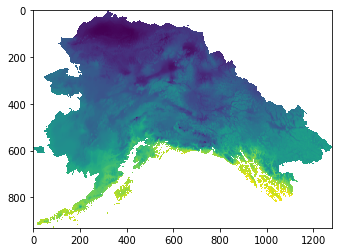

In [21]:
plot_sample_tif(tas_out_fps[0])

### Precipitation

In [22]:
varname = "pr"
data_dir_name = f"cru_ts40_2km_monthly_{varname}"
src_dir = scratch_dir.joinpath(data_dir_name)

pr_out_fps = run_preprocessing(src_dir, varname)

Summarizing DJF from /atlas_scratch/kmredilla/iem-webapp/cru_ts40_2km_monthly_pr
Reading GeoTIFFs into a single array...

  0%|          | 0/345 [00:00<?, ?it/s]

done.
Summarizing MAM from /atlas_scratch/kmredilla/iem-webapp/cru_ts40_2km_monthly_pr
Reading GeoTIFFs into a single array...

  0%|          | 0/345 [00:00<?, ?it/s]

done.
Summarizing JJA from /atlas_scratch/kmredilla/iem-webapp/cru_ts40_2km_monthly_pr
Reading GeoTIFFs into a single array...

  0%|          | 0/345 [00:00<?, ?it/s]

done.
Summarizing SON from /atlas_scratch/kmredilla/iem-webapp/cru_ts40_2km_monthly_pr
Reading GeoTIFFs into a single array...

  0%|          | 0/345 [00:00<?, ?it/s]

done.
Clipping rasters to IEM domain...


  0%|          | 0/32 [00:00<?, ?it/s]

All IEM rasters clipped and written to /atlas_scratch/kmredilla/iem-webapp/cru_ts40_2km_monthly_pr_iem_domain


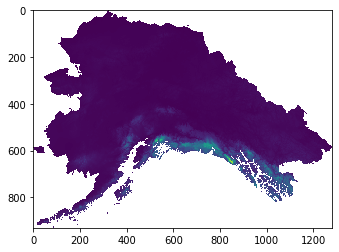

In [23]:
plot_sample_tif(pr_out_fps[0])